In [1]:
import random
import os
import shutil

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.datasets as dsets
import torchvision

from scipy.ndimage.filters import gaussian_filter
import PIL
from PIL import Image

random.seed(42)

In [2]:
class resBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, k=3, s=1, p=1):
        super(resBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, k, stride=s, padding=p)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, k, stride=s, padding=p)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        return self.bn2(self.conv2(y)) + x
    
class resTransposeBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, k=3, s=1, p=1):
        super(resTransposeBlock, self).__init__()

        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, k, stride=s, padding=p)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, k, stride=s, padding=p)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        return self.bn2(self.conv2(y)) + x
    
class VGG19_extractor(nn.Module):
    def __init__(self, cnn):
        super(VGG19_extractor, self).__init__()
        self.features1 = nn.Sequential(*list(cnn.features.children())[:3])
        self.features2 = nn.Sequential(*list(cnn.features.children())[:5])
        self.features3 = nn.Sequential(*list(cnn.features.children())[:12])
    def forward(self, x):
        return self.features1(x), self.features2(x), self.features3(x)

In [3]:
vgg19_exc = VGG19_extractor(torchvision.models.vgg19(pretrained=True))
vgg19_exc = vgg19_exc.cuda()

### Designing Encoder (E)

In [4]:
class Encoder(nn.Module):
    def __init__(self, n_res_blocks=5):
        super(Encoder, self).__init__()
        self.n_res_blocks = n_res_blocks
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_1' + str(i+1), resBlock(in_channels=64, out_channels=64, k=3, s=1, p=1))
        self.conv2 = nn.Conv2d(64, 32, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_2' + str(i+1), resBlock(in_channels=32, out_channels=32, k=3, s=1, p=1))
        self.conv3 = nn.Conv2d(32, 8, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_3' + str(i+1), resBlock(in_channels=8, out_channels=8, k=3, s=1, p=1))
        self.conv4 = nn.Conv2d(8, 1, 3, stride=1, padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_1'+str(i+1))(y))
        y = F.relu(self.conv2(y))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_2'+str(i+1))(y))
        y = F.relu(self.conv3(y))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_3'+str(i+1))(y))
        y = self.conv4(y)
        return y

E1 = Encoder(n_res_blocks=10)

### Designing Decoder (D)

In [5]:
class Decoder(nn.Module):
    def __init__(self, n_res_blocks=5):
        super(Decoder, self).__init__()
        self.n_res_blocks = n_res_blocks
        self.conv1 = nn.ConvTranspose2d(1, 8, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_1' + str(i+1), resTransposeBlock(in_channels=8, out_channels=8, k=3, s=1, p=1))
        self.conv2 = nn.ConvTranspose2d(8, 32, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_2' + str(i+1), resTransposeBlock(in_channels=32, out_channels=32, k=3, s=1, p=1))
        self.conv3 = nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_3' + str(i+1), resTransposeBlock(in_channels=64, out_channels=64, k=3, s=1, p=1))
        self.conv4 = nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_1'+str(i+1))(y))
        y = F.relu(self.conv2(y))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_2'+str(i+1))(y))
        y = F.relu(self.conv3(y))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_3'+str(i+1))(y))
        y = self.conv4(y)
        return y

D1 = Decoder(n_res_blocks=10)

### Putting it in box, AE

In [6]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.E = encoder
        self.D = decoder
    def forward(self, x):
        h_enc = self.E(x)
#         print('encoder out checking for nan ', np.isnan(h_enc.data.cpu()).any())
        y = self.D(h_enc)
#         print('decoder out checking for nan ', np.isnan(y.data.cpu()).any())
        return y

In [7]:
A = AE(E1, D1)
A = A.cuda()

### Dataloading and stuff

##### Auto encoder accepts 181X181 as input and outputs 181X181 as output, however the bottle neck output i.e that of encoder is much smaller

a training batch looks like ...


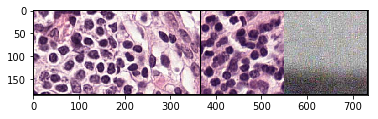

In [8]:
def mynorm2(x):
    m1 = torch.min(x)
    m2 = torch.max(x)
    if m2-m1 < 1e-6:
        return x-m1
    else:
#         return x-m1
        return (x-m1)/(m2-m1)

mytransform2 = transforms.Compose(
    [transforms.RandomCrop((181,181)),
#      transforms.Lambda( lambda x : Image.fromarray(gaussian_filter(x, sigma=(10,10,0)) )),
#      transforms.Resize((41,41)),
     transforms.ToTensor(),
     transforms.Lambda( lambda x : mynorm2(x) )])
#      ])

trainset = dsets.ImageFolder(root='../sample_dataset/train/',transform=mytransform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = dsets.ImageFolder(root='../sample_dataset/test/',transform=mytransform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)
# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def imshow2(img):
    m1 = torch.min(img)
    m2 = torch.max(img)
#     img = img/m2
    if m2-m1 < 1e-6:
        img = img/m2
    else:
        img = (img-m1)/(m2-m1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #all the images under the same 'unlabeled' folder
# print(labels)
# show images
print('a training batch looks like ...')
imshow(torchvision.utils.make_grid(images))

### Some more visualisation

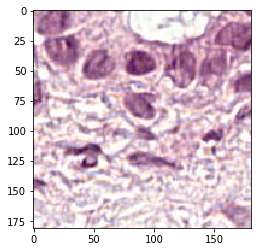

In [24]:
dataiter = iter(trainloader)
images, labels = next(dataiter) #all the images under the same 'unlabeled' folder
imshow(torchvision.utils.make_grid(images[0,:,:,:]))

### training thingy

In [25]:
def save_model(model, model_name):
    try:
        os.makedirs('../saved_models')
    except OSError:
        pass
    torch.save(model.state_dict(), '../saved_models/'+model_name)
    print('model saved at '+'../saved_models/'+model_name)

In [38]:
# dataloader = iter(trainloader)
testiter = iter(testloader)

In [41]:
def eval_model(model):
    testX, _ = next(testiter)
    model.cpu()
    X = testX
    print('input looks like ...')
    plt.figure()
    imshow(torchvision.utils.make_grid(X))
    X = Variable(X)
    Y = model(X)
    print('output looks like ...')
    plt.figure()
    imshow2(torchvision.utils.make_grid(Y.data.cpu()))
    
    return X

In [30]:
A.load_state_dict(torch.load('../saved_models/camelyon16_AE_181_last.pth'))
A = A.cuda()

input looks like ...
output looks like ...


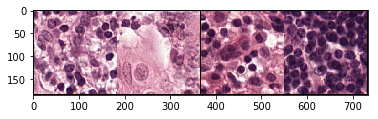

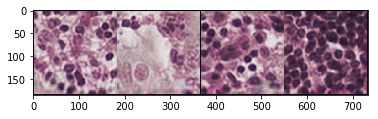

In [47]:
shownX = eval_model(A)

#### Encoded space is shown below, encoded space is 1X46X46

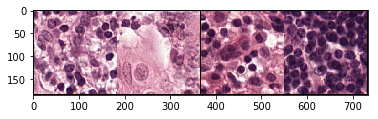

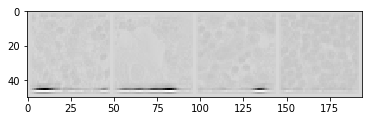

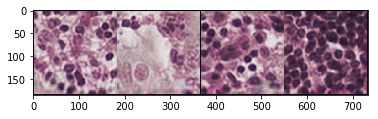

In [52]:
plt.figure()
imshow(torchvision.utils.make_grid(shownX.data))
Y1 = A.E(Variable(shownX.data))
plt.figure()
imshow2(torchvision.utils.make_grid(Y1.data))
Z1 = A.D(Y1)
plt.figure()
imshow2(torchvision.utils.make_grid(Z1.data))

In [99]:
tis = np.zeros((4,1,46,46))
for i in range(4):
    t = Y1.data.numpy()[i,0,:,:]
    m = np.min(t)
    M = np.max(t)
    tis[i,0,:,:] = (t-m)/(M-m)

In [100]:
tis

array([[[[ 0.84757113,  0.82523078,  0.83019775, ...,  0.81750357,
           0.84018284,  0.84616297],
         [ 0.83664179,  0.80101699,  0.82594377, ...,  0.81687391,
           0.85843223,  0.83468282],
         [ 0.83813542,  0.79286462,  0.80220979, ...,  0.84397399,
           0.84571779,  0.83503979],
         ..., 
         [ 0.78825724,  0.65209514,  0.50819021, ...,  0.58396387,
           0.65712982,  0.76295745],
         [ 0.85671264,  0.88022596,  0.92350018, ...,  0.93294388,
           0.9034707 ,  0.86759937],
         [ 0.82369083,  0.78699362,  0.72566509, ...,  0.74732488,
           0.77033085,  0.80103219]]],


       [[[ 0.83569175,  0.81963187,  0.82037133, ...,  0.82056838,
           0.81781608,  0.82734215],
         [ 0.82246655,  0.81199276,  0.80873758, ...,  0.82288206,
           0.81886339,  0.82838929],
         [ 0.82725185,  0.790672  ,  0.80923998, ...,  0.822285  ,
           0.82216167,  0.82412928],
         ..., 
         [ 0.80431354,  0.7586

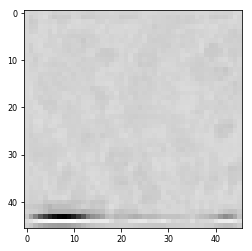

In [101]:
plt.imshow(tis[0,0,:,:], cmap='gray')

In [102]:
from skimage import data, img_as_float
from skimage import exposure
matplotlib.rcParams['font.size'] = 8

ti_rescale = np.zeros((4,1,46,46))
ti_eq = np.zeros((4,1,46,46))
ti_adapteq = np.zeros((4,1,46,46))

for i in range(4):
    img = tis[i,0,:,:]
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    img_eq = exposure.equalize_hist(img)
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    ti_rescale[i,0,:,:] = img_rescale
    ti_eq[i,0.:,:] = img_eq
    ti_adapteq[i,0,:,:] = img_adapteq

/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


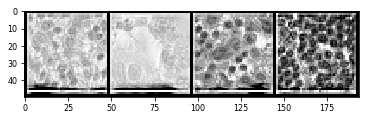

In [105]:
imshow2(torchvision.utils.make_grid(torch.from_numpy(ti_rescale)))

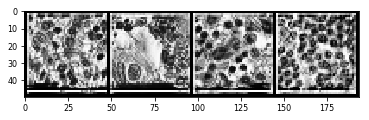

In [106]:
imshow2(torchvision.utils.make_grid(torch.from_numpy(ti_eq)))

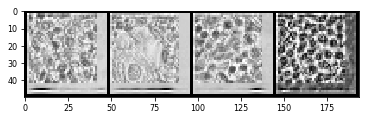

In [107]:
imshow2(torchvision.utils.make_grid(torch.from_numpy(ti_adapteq)))

In [108]:
A.E

Encoder(
  (conv1): Conv2d (3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (residual_block_11): resBlock(
    (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (residual_block_12): resBlock(
    (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (residual_block_13): resBlock(
    (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  